# Prediction of energy consumption of daily energy demand and market price in Spain

**July 2019**

**Project Description:**

We will use this dataset to analyse and predict the energy demand in Spain. Further we will look at the development of the daily market price. While this might sound easy, it is actually a quite hard task since the whole country undergoes a variety of seasonal (repetitive) and non-seasonal (discrete) flucutations, caused e.g. by weather seasons, by political events / decisions or societal influences.

**Data Description:**

This notebook deals with the analysis of a daily time series of electricity demand, generation and prices in Spain from 2014 to 2018. The data (including its documentation) is accessible through kaggle: https://www.kaggle.com/manualrg/spanish-electricity-market-demand-gen-price

---

## Data Analysis
We start our analysis by importing required libraries:

In [1]:
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt; plt.style.use('seaborn-colorblind')
import seaborn as sns; sns.set(style="ticks", color_codes=True)
import time
from datetime import datetime as dt

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from IPython.display import display
from sklearn import metrics

from fastai.tabular import *

import os
from IPython.display import display
pd.set_option('display.max_columns', None) # display all columns

import warnings
warnings.filterwarnings("ignore")

We load the data and drop some columns that dont seem to be useful for our analysis:

In [2]:
PATH = 'spain_energy_market.csv'
df = pd.read_csv(PATH, parse_dates = True, date_parser = 'datetime')

Let's have a look at the data:

In [3]:
df.head()

,datetime,id,name,geoid,geoname,value
0,2014-01-01 23:00:00,600,Precio mercado SPOT Diario ESP,3.0,España,25.280833
1,2014-01-02 23:00:00,600,Precio mercado SPOT Diario ESP,3.0,España,39.924167
2,2014-01-03 23:00:00,600,Precio mercado SPOT Diario ESP,3.0,España,4.992083
3,2014-01-04 23:00:00,600,Precio mercado SPOT Diario ESP,3.0,España,4.091667
4,2014-01-05 23:00:00,600,Precio mercado SPOT Diario ESP,3.0,España,13.587500


Lets create additional Time data columns:

In [4]:
df['date'] = pd.to_datetime(df['datetime'])
df['dayofweek'] = df['date'].dt.dayofweek
df['quarter'] = df['date'].dt.quarter
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['dayofyear'] = df['date'].dt.dayofyear
df['dayofmonth'] = df['date'].dt.day
df['weekofyear'] = df['date'].dt.weekofyear
df = df.set_index(['date'])

In [5]:
df.drop(['datetime'], axis=1,inplace=True)

In [6]:
df['name'].unique()

array(['Precio mercado SPOT Diario ESP', 'Precio mercado SPOT Diario FRA', 'Precio mercado SPOT Diario POR',
       'Energía asignada en Mercado SPOT Diario España', 'Energía asignada en Mercado SPOT Diario Francia', nan,
       'Rentas de congestión mecanismos implícitos diario Francia exportación',
       'Rentas de congestión mecanismos implícitos diario Portugal exportación',
       'Rentas de congestión mecanismos implícitos diario Francia importación',
       'Rentas de congestión mecanismos implícitos diario Portugal importación', 'Demanda real',
       'Demanda programada PBF total', 'Generación programada PBF total', 'Generación programada PBF Eólica',
       'Generación programada PBF Ciclo combinado', 'Generación programada PBF Carbón',
       'Generación programada PBF Nuclear', 'Generación programada PBF Gas Natural Cogeneración',
       'Generación programada PBF UGH + no UGH', 'Generación programada PBF Solar fotovoltaica',
       'Generación programada PBF Turbinación b

Since multiple time series are contained in our column data, we need to seperate the different features. Lets create new dataframes of the 'real Demand' the 'scheduled Demand' and the 'Daily spot Spain market price'.

In [7]:
Demand_real  = df[df['name'] == 'Demanda real']
Demand_sche  = df[df['name'] == 'Demanda programada PBF total']
Price        = df[df['name'] == 'Precio mercado SPOT Diario ESP']
Price.head()

,id,name,geoid,geoname,value,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
date,,,,,,,,,,,,
2014-01-01 23:00:00,600,Precio mercado SPOT Diario ESP,3.0,España,25.280833,2,1,1,2014,1,1,1
2014-01-02 23:00:00,600,Precio mercado SPOT Diario ESP,3.0,España,39.924167,3,1,1,2014,2,2,1
2014-01-03 23:00:00,600,Precio mercado SPOT Diario ESP,3.0,España,4.992083,4,1,1,2014,3,3,1
2014-01-04 23:00:00,600,Precio mercado SPOT Diario ESP,3.0,España,4.091667,5,1,1,2014,4,4,1
2014-01-05 23:00:00,600,Precio mercado SPOT Diario ESP,3.0,España,13.587500,6,1,1,2014,5,5,1


Price development over whole timespan:

Text(0, 0.5, '€/MWh')

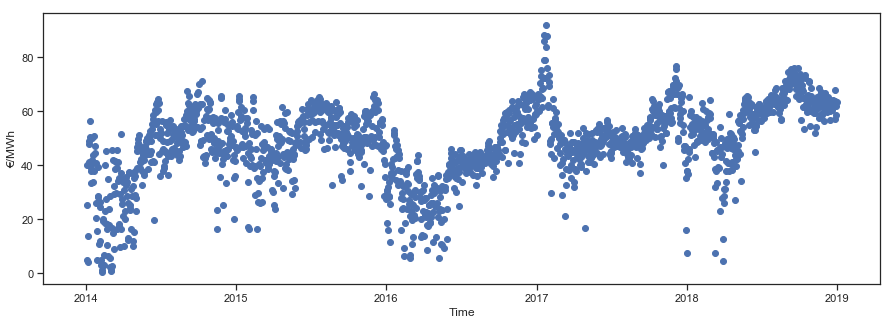

In [12]:
plt.figure(figsize=(15,5))
plt.scatter(x=Price.index,y=Price['value'])
plt.xlabel("Time")
plt.ylabel("€/MWh")

We can see that the price development undergoes some seasonal changes. To further explore this, lets visualize the data for different time attributes, like price per day of week, week of year, quarter and year.

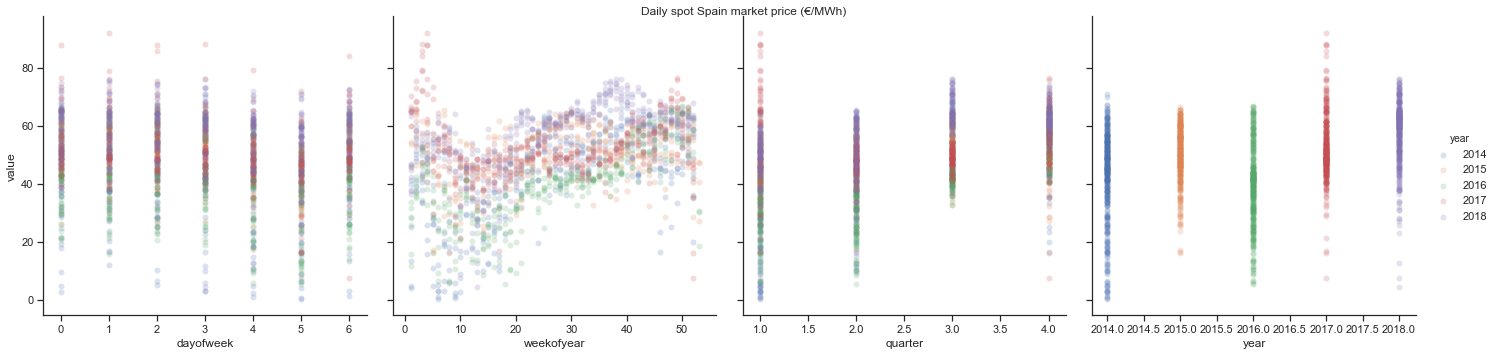

In [9]:
sns.pairplot(Price,
             hue='year',
             x_vars=['dayofweek','weekofyear','quarter','year'],
             y_vars='value',
             height=5,
             plot_kws={'alpha':0.2, 'linewidth':0}
            )
plt.suptitle('Daily spot Spain market price (€/MWh)')
plt.show()

We repeat this for the expected energy demand and the actual demand...

<Figure size 1152x720 with 0 Axes>

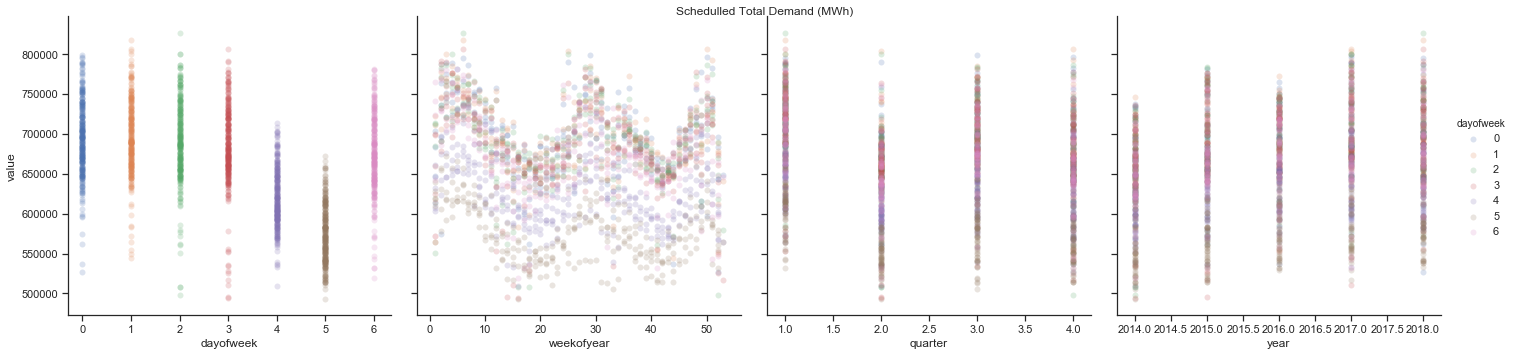

In [10]:
plt.figure(figsize=(16,10))
sns.pairplot(Demand_sche,
             hue='dayofweek',
             x_vars=['dayofweek','weekofyear','quarter','year'],
             y_vars='value',
             height=5,
             plot_kws={'alpha':0.2, 'linewidth':0}
            )
plt.suptitle('Schedulled Total Demand (MWh)')
plt.show()

<Figure size 1080x720 with 0 Axes>

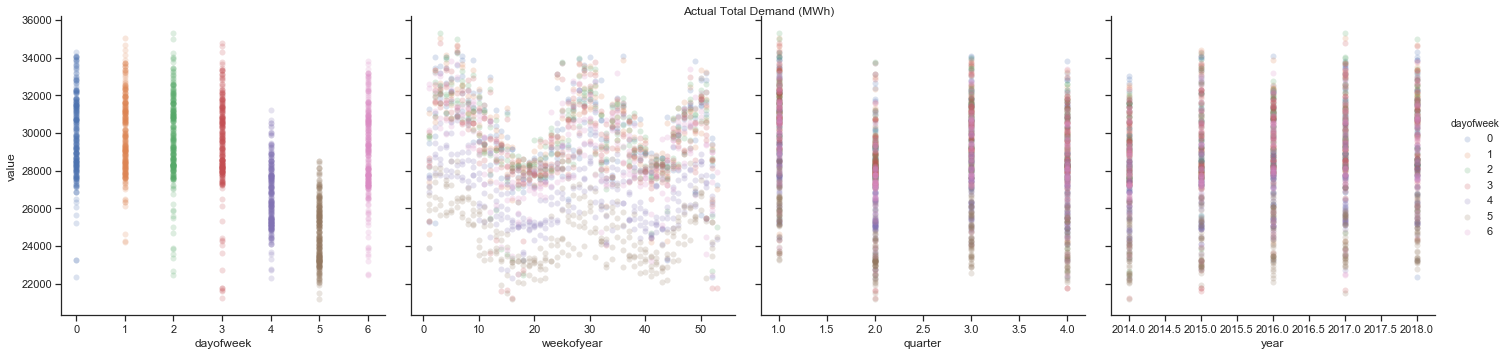

In [14]:
plt.figure(figsize=(15,10))
sns.pairplot(Demand_real,
             hue='dayofweek',
             x_vars=['dayofweek','weekofyear','quarter','year'],
             y_vars='value',
             height=5,
             plot_kws={'alpha':0.2, 'linewidth':0}
            )
plt.suptitle('Actual Total Demand (MWh)')
plt.show()

### Observations

Based on our quick visualization we can derive the following observations:

- the daily market price has a long-term dependency (quarterly or yearly fluctuations), while
- the demand seems to be strongly influenced by the days of the week (see drop on weekend)

## Prediction of daily energy demand

We want to predict the real energy demand. We start by splitting the data into training and test set. Lets take the 2018-01-01 as split-date.

In [15]:
date_split = '2018-01-01'
train = Demand_real['value'].loc[Demand_real.index <= date_split].copy()
train = train.reset_index()
test = Demand_real['value'].loc[Demand_real.index > date_split].copy()
test = test.reset_index()
test.head()

,date,value
0,2018-01-01 23:00:00,28543.972222
1,2018-01-02 23:00:00,29820.423611
2,2018-01-03 23:00:00,29839.680556
3,2018-01-04 23:00:00,28678.284722
4,2018-01-05 23:00:00,25254.416667


Text(0, 0.5, 'Energy demand (MWh)')

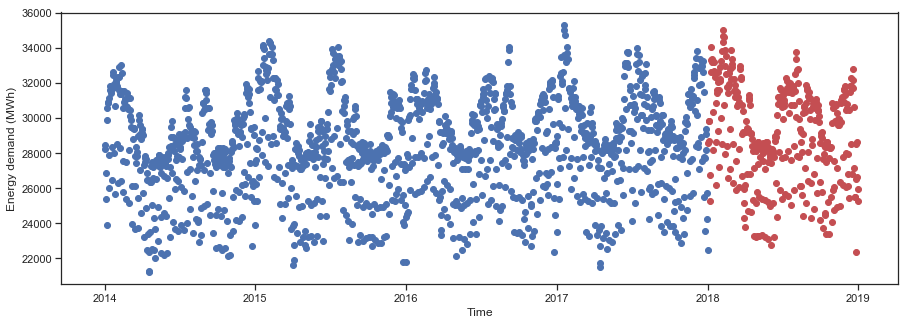

In [16]:
plt.figure(figsize=(15,5))
plt.scatter(x=train['date'],y=train['value'],c='b')
plt.scatter(x=test['date'],y=test['value'],c='r')
plt.xlabel('Time')
plt.ylabel('Energy demand (MWh)')

Now, we train a Prophet model from Facebook (https://facebook.github.io/prophet/), used to forecast time series that undergo seasonal trends.

In [17]:
from fbprophet import Prophet

In [18]:
model = Prophet()
model.fit(train.rename(columns={'date':'ds', 'value':'y'}))

In [19]:
demand_predict = model.predict(df=test.rename(columns={'date':'ds'}))

The predictions can easily be visualized against our test set:

Text(90.75, 0.5, 'Energy demand (MWh)')

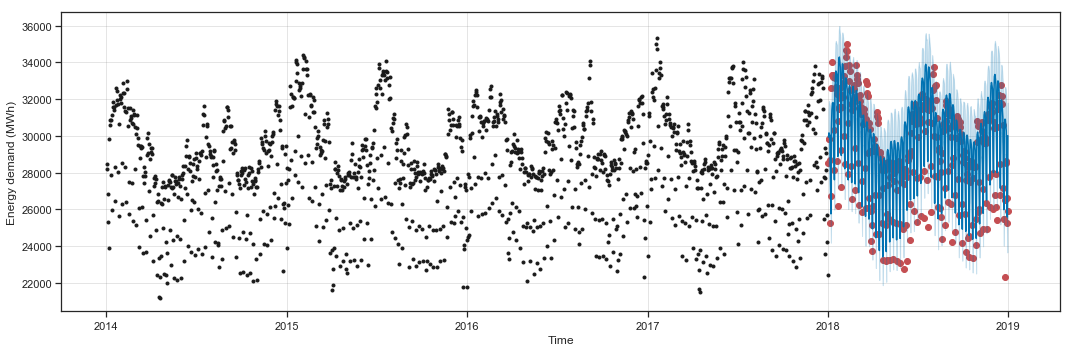

In [20]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(test['date'], test['value'], color='r')
fig = model.plot(demand_predict, ax=ax)
ax.set_xlabel('Time')
ax.set_ylabel('Energy demand (MWh)')

And the first month of the forecast:

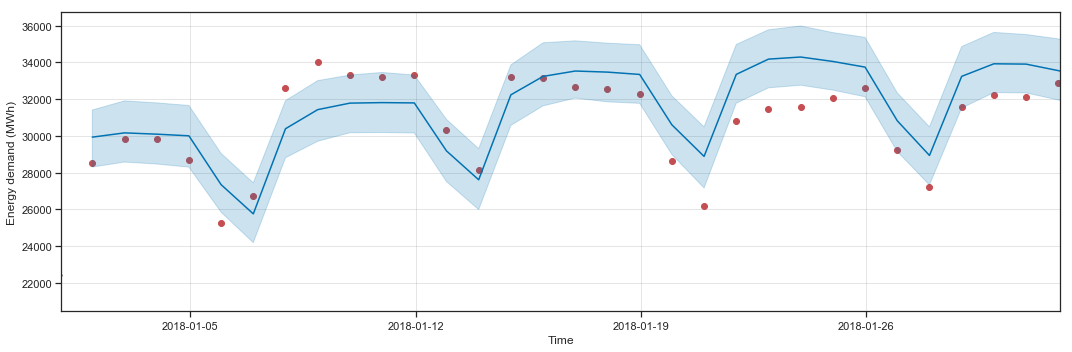

In [22]:
date_start = dt.fromtimestamp(time.mktime(dt.strptime(date_split, "%Y-%m-%d").timetuple()))
date_end = dt.fromtimestamp(time.mktime(dt.strptime('2018-02-01', "%Y-%m-%d").timetuple()))

f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(test['date'], test['value'], color='r')
fig = model.plot(price_predict, ax=ax)
plt.xlim(1, 30)
ax.set_xlabel('Time')
ax.set_ylabel('Energy demand (MWh)')
ax.set_xbound(lower=date_start, upper=date_end)

## Prediction of daily price

Lets see if we can predict the market price. We start by splitting the data into training and test set. Lets take the 2018-01-01 as split-date.

In [23]:
date_split = '2018-01-01'
train = Price['value'].loc[Price.index <= date_split].copy()
train = train.reset_index()
test = Price['value'].loc[Price.index > date_split].copy()
test = test.reset_index()
test.head()

,date,value
0,2018-01-01 23:00:00,37.690000
1,2018-01-02 23:00:00,37.947917
2,2018-01-03 23:00:00,36.551667
3,2018-01-04 23:00:00,42.204583
4,2018-01-05 23:00:00,45.844167


Text(0, 0.5, 'Market price (€/MWh)')

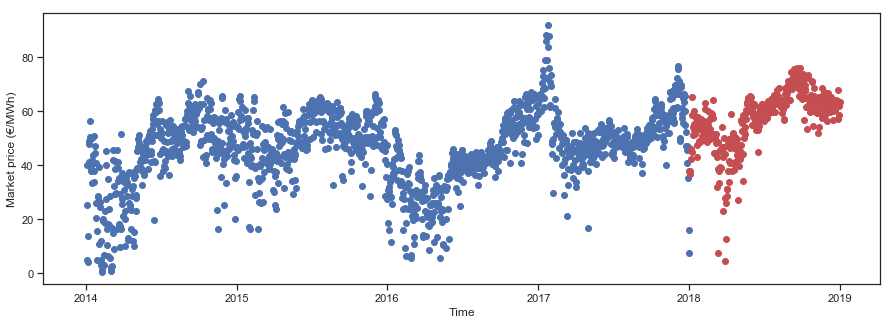

In [25]:
plt.figure(figsize=(15,5))
plt.scatter(x=train['date'],y=train['value'],c='b')
plt.scatter(x=test['date'],y=test['value'],c='r')
plt.xlabel('Time')
plt.ylabel('Market price (€/MWh)')

Redo the previous steps:

In [26]:
model = Prophet()
model.fit(train.rename(columns={'date':'ds', 'value':'y'}))

Forcasting from training set:

In [27]:
price_predict = model.predict(df=test.rename(columns={'date':'ds'}))

Let's see the forecast (and compare against actual data):

Text(109.125, 0.5, 'Market price (€/MWh)')

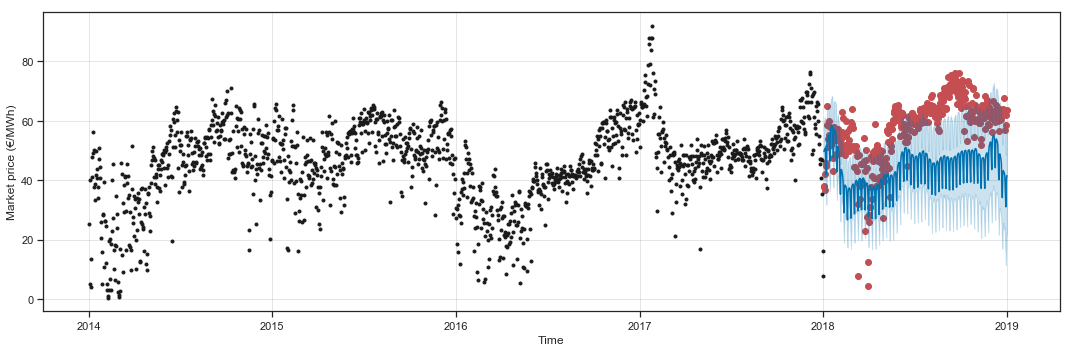

In [28]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(test['date'], test['value'], color='r')
fig = model.plot(price_predict, ax=ax)
ax.set_xlabel('Time')
ax.set_ylabel('Market price (€/MWh)')

Ok, that does not look to good. Lets see if we can get better predictions, if we exclude data that is to old, e.g. earlier than 2016. 

In [31]:
date_start = '2016-01-01'
train = train.loc[train['date'] >= date_start].copy()
train.head(1)

,date,value
730,2016-01-01 23:00:00,30.725


Retrain the model:

In [32]:
model2 = Prophet()
model2.fit(train.rename(columns={'date':'ds', 'value':'y'}))

In [33]:
future = model2.make_future_dataframe(periods=365)
future.tail(1)

,ds
1095,2018-12-31 23:00:00


In [34]:
forecast = model2.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1091,2018-12-27 23:00:00,48.511035,39.641667,57.285901
1092,2018-12-28 23:00:00,43.779627,34.737749,52.443686
1093,2018-12-29 23:00:00,39.208361,30.298943,48.098689
1094,2018-12-30 23:00:00,46.985464,37.673747,55.514224
1095,2018-12-31 23:00:00,49.728160,41.509477,57.843914


Text(64.125, 0.5, 'Market price (€/MWh)')

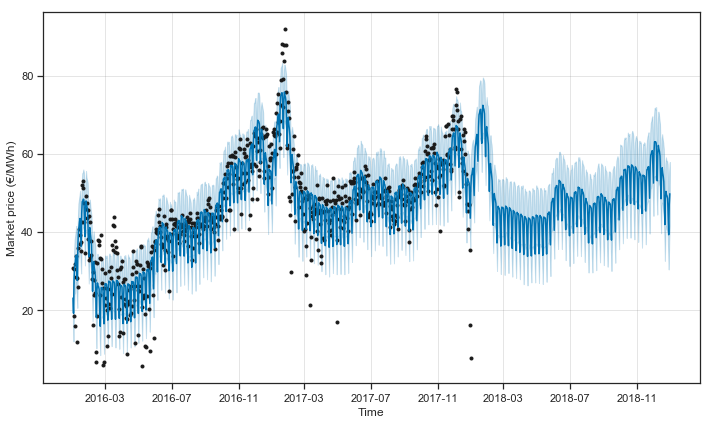

In [36]:
fig1 = model2.plot(forecast)
plt.xlabel('Time')
plt.ylabel('Market price (€/MWh)')

In [37]:
price_predict2 = model2.predict(df=test.rename(columns={'date':'ds'}))

Text(109.125, 0.5, 'Market price (€/MWh)')

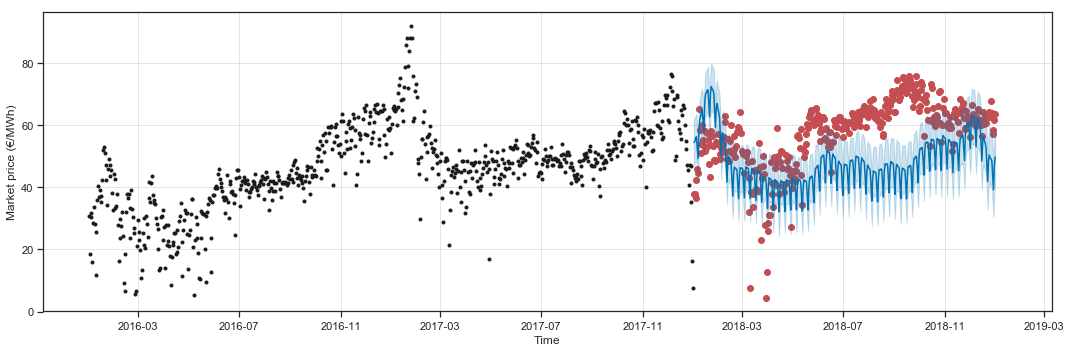

In [38]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(test['date'], test['value'], color='r')
fig = model2.plot(price_predict2, ax=ax)
ax.set_xlabel('Time')
ax.set_ylabel('Market price (€/MWh)')

The prediction still does not seem to describe our data well. Yearly, weekly and daily trends can be seen in the following figure:

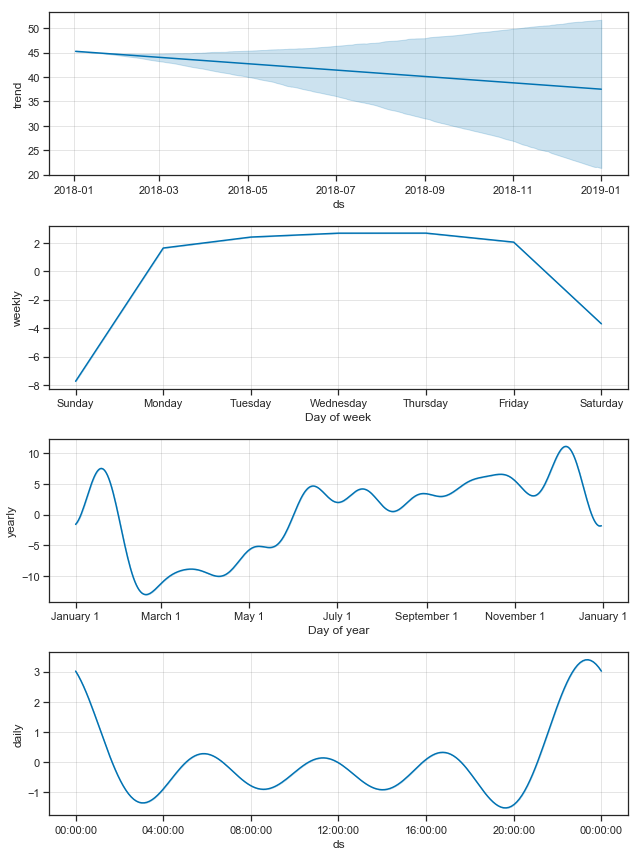

In [39]:
fig = model.plot_components(price_predict)

---


We can also try to include holiday information:

In [40]:
from workalendar.europe import Spain
cal = Spain()
holdidays_2018 = cal.holidays(2018)
holdidays_2018[0]

(datetime.date(2018, 1, 1), 'New year')

In [41]:
train_holidays = cal.holidays(start=train['date'].min(), end=train['date'].max())
test_holidays = cal.holidays(start=train['date'].min(), end=test['date'].max())

TypeError: holidays() got an unexpected keyword argument 'start'